# Çok Faktörlü Modeller

Bu modellerin arkasındaki fikir, belirli bir portföyün veya varlığın fazla getirilerini (risksiz oran üzerinden) bir veya daha fazla faktör (özellik) kullanarak açıklamaktır. Bu risk faktörleri (beklenen) getirilerin kesitini(cross-section) anlamak için bir araç olarak düşünülebilir.

Genel olarak, yatırım portföyüne eklenebilecek ilginç varlıkları tanımlamak için faktör modelleri kullanılabilir ve bu da daha iyi performans gösteren portföylere yol açar.

Bu başlıkta ele alınacaklar:

* Sermaye Varlıkları Fiyatlandırma Modeli(Capital Asset Pricing Model-CAPM)
* Fama-French üç faktörlü model
* Varlık portfolyosu üzerinde hareketli üç faktör modeli
* Dört ve beş faktörlü modeller

# 1. Sermaye Varlık Fiyatlama Modeli-SVFM (Capital Asset Pricing Model-CAPM)

Popüler SVFM tahmini ve beta katsayılarının elde edilmesine odaklanılacak. Bu model, bir riskli varlığın beklenen getirisi ile piyasa riski (sistematik veya indirgenemez risk olarak da bilinir) arasındaki ilişkiyi temsil eder. SVFM, daha karmaşık faktör modellerinin oluşturulduğu tek faktörlü bir model olarak düşünülebilir.

SVFM modelini aşağıdaki eşitlikle gösterebiliriz:

$$E\left(r_{i}\right)=r_{f}+\beta_{i}\left(E\left(r_{m}\right)-r_{f}\right)$$

Burada $E\left(r_{i}\right)$, $i$ varlığı için beklenen getiriyi, $r_{f}$ riskten bağımsız faiz oranı(devlet tahvili gibi), $E\left(r_{m}\right)$ piyasadakii beklenen getiri, $\beta_{i}$ beta katsayısıdır. 

Beta, genel olarak piyasaya kıyasla varlık getirisinin hassasiyet seviyesi olarak yorumlanabilir. Bazı olası örnekler şunları içerir:

* `beta <= -1`: Varlık, karşılaştırma ölçütü olarak ters yönde ve karşılaştırmalı değerlendirmenin negatifinden daha büyük bir miktarda hareket eder.
* `-1 < beta < 0`: Varlık, karşılaştırmalı değerlendirmenin tersi yönde hareket eder.
* `beta = 0`: Varlığın fiyat hareketi ile piyasa karşılaştırması arasında bir ilişki yoktur.
* `0 <beta <1`: Varlık, piyasa ile aynı yönde hareket eder, ancak miktar daha küçüktür. Günlük dalgalanmalara pek duyarlı olmayan bir şirketin hisse senedi buna örnek gösterilebilir.
* `beta = 1`: Varlık ve piyasa aynı yönde aynı miktarda hareket ediyor.
* `beta> 1`: Varlık, piyasa ile aynı yönde hareket eder, ancak tutar daha fazladır. Günlük piyasa haberlerine çok duyarlı bir şirketin hisse senedi buna örnek gösterilebilir.

SVFM aşağıdaki gibi de yazılabilir:

$$E\left(r_{i}\right)-r_{f}=\beta_{i}\left(E\left(r_{m}\right)-r_{f}\right)$$

Burada, denklemin sol tarafı risk primi(risk premium) olarak yorumlanırken, sağ tarafı piyasa primini(market premium) içerir. Eşitlik aşağıdaki gibi yeniden yazılabilir:

$$\beta=\frac{\operatorname{cov}\left(R_{i}, R_{m}\right)}{\operatorname{var}\left(R_{m}\right)}$$

Burada $R_{i}=E\left(r_{i}\right)-r_{f}$ and $R_{m}=E\left(r_{m}\right)-r_{\mathrm{f}}$ şeklindedir.

Buradaki örnekte, Amazon örneğini ele alıyoruz ve S&P 500 endeksinin piyasayı temsil ettiğini varsayıyoruz. Beta'yı tahmin etmek için 5 yıllık (2014-2018) aylık veriler kullanıyoruz. Mevcut zamanlarda, risksiz oran o kadar düşük ki, basitlik olarak, sıfıra eşit olduğunu varsayıyoruz.

In [1]:
# kütüphaneler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# matplotlib
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# dataset
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

Riskli varlık ve zaman periyodu:

In [2]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

Yahoo finanstan verinin alınması:

In [3]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

Günlük verinin aylıkveriye dönüştürülmesi ve basit getirilerin hesaplanması:

In [4]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()

,asset,market
Date,,
2014-01-31,-0.100554,-0.035583
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030


Kovaryans yaklaşımı ile `beta`nın hesaplanması:

In [5]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

In [6]:
print(f"The result of the code is beta = {beta}")

The result of the code is beta = 1.6709216959340019


Girdinin hazırlanıp SVFM nin doğrusal regresyon olarak tahmin edilmesi: 

In [7]:
y = X.pop('asset')
X = sm.add_constant(X)

capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     35.63
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           1.53e-07
Time:                        18:34:13   Log-Likelihood:                 76.708
No. Observations:                  60   AIC:                            -149.4
Df Residuals:                      58   BIC:                            -145.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.009      1.842      0.0

Bu sonuçlar, beta'nın (burada piyasa olarak ifade edilir) 1,67'ye eşit olduğunu gösterir, bu da Amazon'un getirilerinin piyasadan %67 daha volatil olduğu anlamına gelir (S&P 500 ile temsil edilir). Sabitin değeri nispeten küçüktür ve %5 anlamlılık düzeyinde istatistiksel olarak anlamsızdır.

Örnekte, bugünlerde yapmak için makul bir varsayım olan risksiz bir oran olmadığı varsayılmıştır. Bununla birlikte, sıfır olmayan risksiz bir oranı açıklamak istediğimiz durumlar olabilir. Burada üç olası yaklaşım sunulmaktadır:

* Kenneth French'in sitesindeki veriyi kullanarak: Piyasa primi $\left(r_{m}-r_{f}\right)$ ve riskten bağımsız faiz oranı(hazine bonosuyla yakınsar) siteden indirilebilir.
* İkinci seçenek, örneğin 13 Haftalık (3 aylık) Hazine Bonosu (Yahoo finans senedi: `^IRX`) ile risksiz oranı yaklaşık olarak belirlemektir.

Gün bazında periyodun belirlenmesi:

In [8]:
N_DAYS = 90

Verinin yahoo finance tan indirilmesi:

In [9]:
df_rf = yf.download('^IRX', start=START_DATE, end=END_DATE)

[*********************100%***********************]  1 of 1 completed


Verinin aylık formata dönüştürülmesi:

In [10]:
rf = df_rf.resample('M').last().Close / 100

Riskten bağımsız günlük getirilerin hesaplanıp aylık formata dönüştürülmesi:

In [11]:
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)
rf = (rf ** 30) - 1

Hesaplanan riskten bağımsız oranın çizdirilmesi:

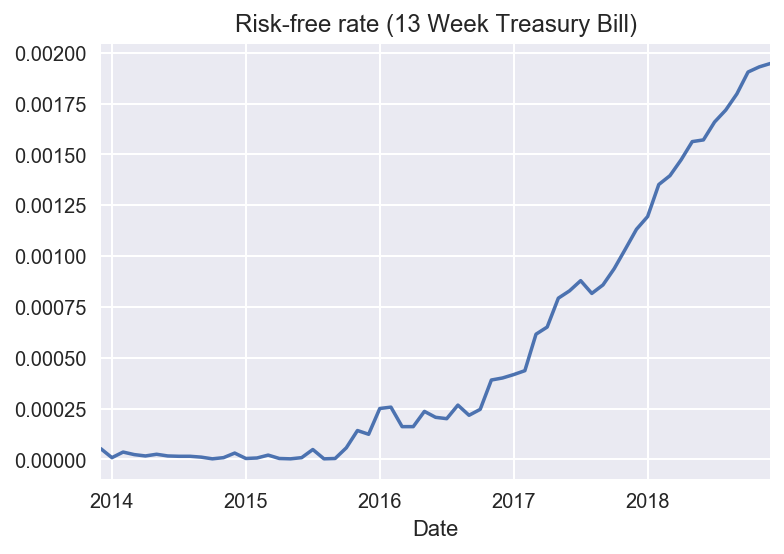

In [12]:
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

* Son yaklaşım, Federal Rezerv Ekonomik Veriler (FRED) veritabanından indirilebilen 3 Aylık Hazine Bonosu (İkincil Piyasa Faiz Oranı) kullanarak risksiz oranı yaklaşık olarak belirlemektir. Verileri nasıl indireceğinizi ve aylık risksiz bir orana nasıl dönüştüreceğinizi öğrenmek için aşağıdaki adımlar izlenebilir.

Kütüphanenin çağırılması:

In [13]:
import pandas_datareader.data as web

FRED veritabanından verinin indirilmesi:

In [14]:
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)

Riskten bağımsız faiz oranının aylık formata dönüştürülmesi:

In [15]:
rf = (1 + (rf / 100)) ** (1 / 12) - 1

Hesaplanan oranın çizdirilmesi:

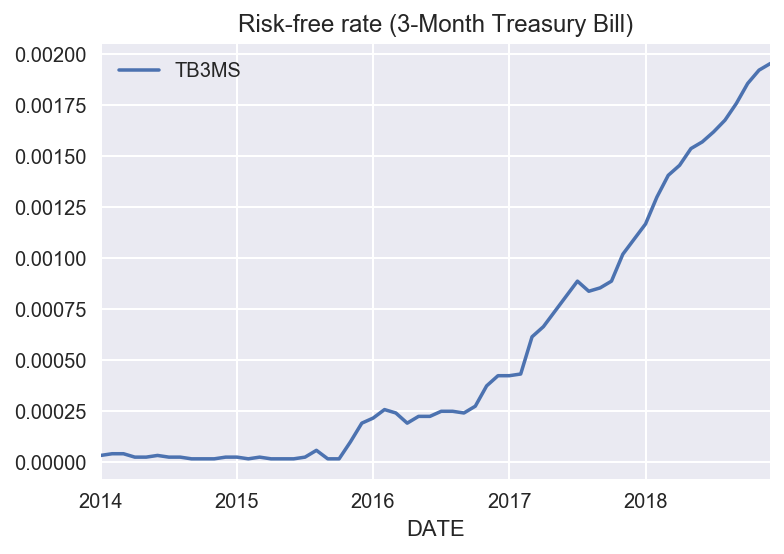

In [16]:
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

# 2. Fama-French Üç Faktör Modeli

Popüler makalelerinde Fama ve Fransız, bir varlık veya portföyün aşırı getirisini açıklayan iki ek faktör ekleyerek SVFM modelini genişletti. Düşündükleri faktörler:

* **Piyasa faktörü (MKT)**: SVFM'dekine benzeyen pazarın aşırı geri dönüşünü ölçer.
* **Boyut faktörü, SMB (Küçük Eksi Büyük)**: Küçük bir piyasa değeri olan hisse senetlerinin büyük bir piyasa değeri olan hisse senetlerinin aşırı getirisini ölçer.
* **Değer faktörü, HML (Yüksek Eksi Düşük)**: Büyüme stokları üzerinden değer stoklarının aşırı geri dönüşünü ölçer. Değer stokları yüksek bir piyasa / piyasa oranına sahipken, büyüme stokları düşük bir oranla karakterize edilir.

Model aşağıdaki gibi gösterilebilir:

$$E\left(r_{i}\right)=r_{f}+\alpha+\beta_{m k t}\left(E\left(r_{m}\right)-r_{f}\right)+\beta_{s m b} S M B+\beta_{h m l} H M L$$

Ya da daha basit biçimiyle:

$$E\left(r_{i}\right)-r_{f}=\alpha+\beta_{m k t} M K T+\beta_{s m b} S M B+\beta_{h m l} H M L$$

Burada $E\left(r_{i}\right)$, i-inci varlık için getiriyi, $r_{f}$ riskten bağımsız faiz oranını ve $\alpha$ sabiti göstermektedir. Sabit bir katasyı eklemenin nedeni, değerinin 0'a eşit olmasını sağlamaktır.

Bu yaklaşımın popülaritesi nedeniyle, bu faktörler topluca Fama-Fransız Faktörleri veya Üç Faktörlü Model olarak bilinmektedir. Akademi ve endüstride borsa ölçütleri olarak geniş çapta kabul görmüşlerdir ve genellikle yatırım performansını değerlendirmek için kullanılırlar.

Burada, üç faktörlü modeli Facebook için 5 yıllık (2014-2018) aylık getiri kullanarak tahmin dilmektedir.

Kütüphanelerin çağırılması:

In [17]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

Verisetinin indirilmesi:

In [20]:
url = "https://raw.githubusercontent.com/erykml/Python-for-Finance-Cookbook/master/Chapter%2004/F-F_Research_Data_Factors.CSV"
factor_df = pd.read_csv(url, skiprows=3)

Parametreler:

In [21]:
RISKY_ASSET = 'FB'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

Aylık veri:

In [22]:
# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

Kolon isimlerinin değiştirilmesi ve filtreleme:

In [23]:
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

Değerlerin sayısal yapılıp 100'e bölünmesi:

In [24]:
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0
2014-02,0.0465,0.0034,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0509,0.0
2014-04,-0.0019,-0.0424,0.0114,0.0
2014-05,0.0206,-0.0186,-0.0027,0.0


Riskli varlık fiyatları:

In [25]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


Riskli varlığın aylık getirilerinin hesplanması:

In [26]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

Verisetlerinin birleştirilip aşırı getirilerin hesaplanması:

In [27]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

Üç-faktör modelinin tahmin edilmesi:

In [28]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     5.175
Date:                Thu, 26 Mar 2020   Prob (F-statistic):            0.00316
Time:                        16:39:03   Log-Likelihood:                 88.392
No. Observations:                  60   AIC:                            -168.8
Df Residuals:                      56   BIC:                            -160.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0105      0.008      1.373      0.1

Üç faktörlü modelin sonuçlarını yorumlarken iki konuya dikkat etmeliyiz:
* Sabitin pozitif ve istatistiksel olarak anlamlı olup olmadığı
* Hangi faktörler istatistiksel olarak anlamlıdır ve yönleri geçmiş sonuçlarla uyumludur (örneğin, literatürden) veya varsayımlarımızla eşleşiyorlar mı

Buradaki örnekte, sabit pozitiftir, ancak %5 anlamlılık düzeyinde istatistiksel olarak anlamlı değildir. Risk faktörlerinden sadece SMB faktörü önemli değildir. Bununla birlikte, faktörler ve etki yönleri hakkında bir hipotez formüle etmek için kapsamlı bir literatür çalışması gereklidir.

Ayrıca, regresyon özetinde sunulan ve regresyonun ortak önemini test eden F-istatistiğine de bakabiliriz. Boş hipotez, sabit hariç tüm özelliklerin (bu durumda faktörler) katsayılarının 0'a eşit değerlere sahip olduğunu belirtir. Karşılık gelen p-değerinin 0.00317 olduğunu görebiliriz, bu da boş hipotezi % 5 önem seviyesinde reddetmemize neden olur.

Fama-French verisetini githubdan çekmiştik. Şimdi bir de bunu `pandas_datareader` ile nasıl yapılacağına bakalım:

Kütüphanelerin çağırılması:

In [29]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

Mevcut verisetlerinin görüntülenmesi:

In [30]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

Belirlenen verisetinin çekilmesi:

In [31]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='2014-01-01')

In [32]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

Verisetinin tanımı:

In [33]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202002 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2020 Kenneth R. French

  0 : (74 rows x 4 cols)
  1 : Annual Factors: January-December (6 rows x 4 cols)


Aylık veriseti:

In [34]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.85,-2.09,0.0
2014-02,4.65,0.34,-0.40,0.0
2014-03,0.43,-1.89,5.09,0.0
2014-04,-0.19,-4.24,1.14,0.0
2014-05,2.06,-1.86,-0.27,0.0


# 3.Bir Varlık Portfolyosu Üzerinde Hareketli Üç Faktör Modelleri

Bu alt-bölümde üç faktörlü modeli hareketli olarak nasıl tahmin edileceği gösterilecektir.. Hareketli ile kastedilen, her zaman sabit büyüklükte bir tahmin penceresini (burada 60 ay) dikkate almamız ve her seferinde bir dönem olmak üzere tüm veri kümesinde hareket ettirmektir. Böyle bir deney yapmanın potansiyel bir nedeni, sonuçların kararlılığını test etmektir.

Önceki alt-bölümlerin aksine, bu kez, tek bir varlık yerine portföy getirileri kullanılacaktır. İşleri basitleştirmek için, dağıtma(allocation) stratejimizin, aşağıdaki hisse senetlerinin her birinde toplam portföyün değerinde eşit bir paya sahip olduğunu varsaymak olacak: Amazon, Google, Apple ve Microsoft. Burada, 2010-2018 yıllarına ait hisse senedi fiyatlarını kullanılacaktır.

Kütüphanelerin çağırılması:

In [41]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import numpy as np

Parametrelerin tanımlanması:

In [36]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

Üç-faktör verisinin alınması:

In [37]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

Riskli varlıkların fiyatlarının alınması:

In [38]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2265 rows of data.


Riskli varlıkların aylık getirilerinin hesaplanması:

In [39]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

Portfolyo getirilerinin hesaplanması:

In [42]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
2010-01,-0.088596,-0.067722,-0.145231,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021625,0.098335
2010-04,0.111021,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016124,-0.084902,-0.076222,-0.151394,-0.082161


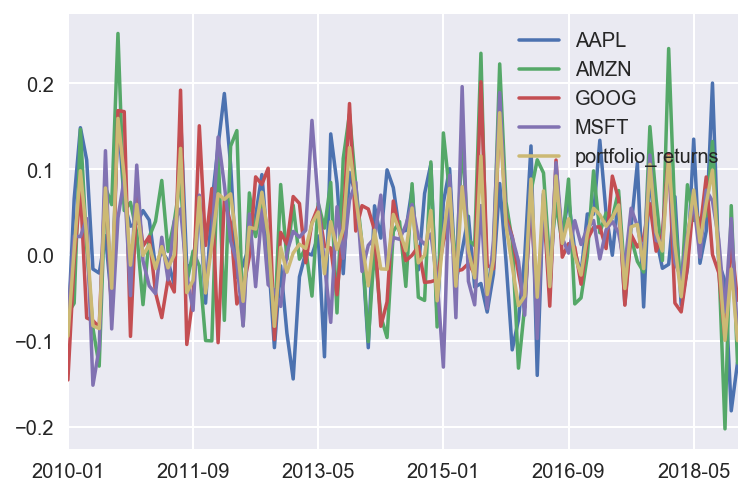

In [43]:
asset_df.plot()

Verisetlerinin birleştirilmesi:

In [44]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [45]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
2010-01,-0.094252,-0.0336,0.0038,0.0030,0.0000,-0.094252
2010-02,0.006430,0.0340,0.0121,0.0316,0.0000,0.006430
2010-03,0.098335,0.0631,0.0143,0.0211,0.0001,0.098235
2010-04,0.022615,0.0200,0.0497,0.0281,0.0001,0.022515
2010-05,-0.082161,-0.0789,0.0005,-0.0238,0.0001,-0.082261


Hareketli n-faktör modelinin tanımlanması:

In [46]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

Hareketli üç faktör modelinin tahmin edilip sonuçlarının çizdirilmesi:

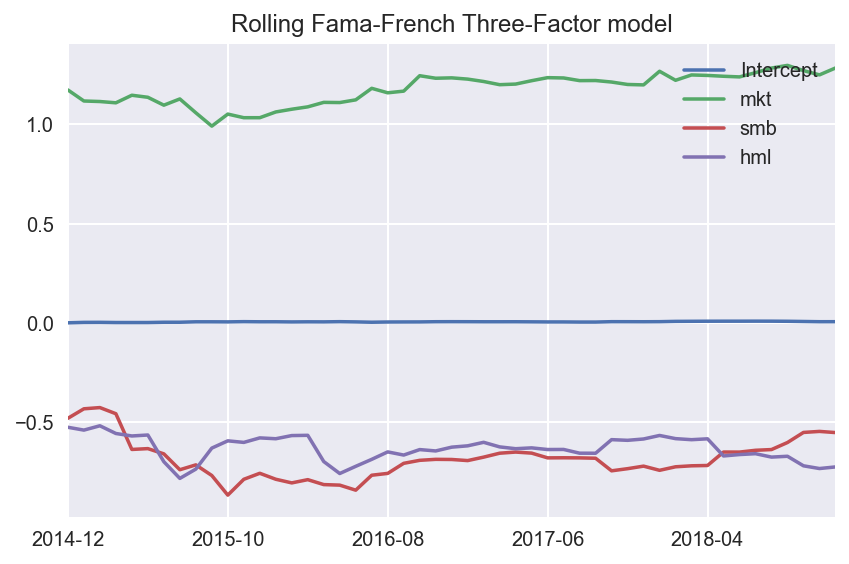

In [47]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()

Grafiği inceleyerek aşağıdakileri görebiliriz:
* Sabit, neredeyse sabittir ve 0'a çok yakındır.
* Faktörlerde bazı değişkenlikler vardır, ancak ani ters dönüşler veya beklenmedik sıçramalar yoktur.

# 4.Dört ve Beş Faktör Modelleri

Burada standart Fama-French modelinin iki uzantısı ele alınacaktır:

* **Carhart'ın Dört Faktör Modeli**: Bu uzantının altında yatan varsayım, kısa bir süre içinde bir kazanan stokun bir kazanan olarak kalacağı, bir kaybedenin ise bir kaybeden olarak kalacağıdır. Kazananları ve kaybedenleri sınıflandırmak için bir ölçüt örneği, son 12 aylık birikimli toplam getiri olabilir. İki grubu belirledikten sonra, kazananları özlüyoruz ve belirli bir bekleme süresi içinde kaybedenleri kısaltıyoruz.

* **Momentum faktörü (WML; Kazananlar Eksi Kaybedenler-winners minus losers)** son 12 ay içinde kazanan hisse senetlerinin kaybeden hisse senetlerinin aşırı getirilerini ölçer.

Dört faktör modeli aşağıdaki gibi ifade edilebilir:

$$E\left(r_{i}\right)-r_{f}=\alpha+\beta_{m k t} M K T+\beta_{s m b} S M B+\beta_{h m l} H M L+\beta_{w m l} W M L$$

Fama-French beş faktör modeli: Fama ve French üç faktör modellerine iki faktörü daha dahil ederler:

* **Sağlam Eksi Zayıf (Robust Minus Weak-RMW):**, yüksek kar marjına (sağlam kârlılık) sahip şirketlerin, düşük karlı (zayıf kârlılık) olanlara göre fazla getirilerini ölçer.
* **Korumacı Eksi Agresif (Conservative Minus Weak-CMA)**, daha düşük yatırım politikaları (korumacı) olan firmaların daha fazla yatırım yapan (agresif) şirketlerden fazla getirisini ölçer.

$$E\left(r_{i}\right)-r_{f}=\alpha+\beta_{m k t} M K T+\beta_{s m b} S M B+\beta_{h m l} H M L+\beta_{r m w} R M W+\beta_{c m a} C M A$$

Tüm faktör modellerinde olduğu gibi, risk faktörlerine maruz kalma beklenen getirilerdeki tüm olası değişiklikleri yakalarsa, tüm varlıklar / portföyler için sabit(α) sıfıra eşit olmalıdır.

Burada Amazon 2014-2018 periyodu için dört ve beş faktör modelleri ele alınacaktır.

Kütüphanelerin çağırılması:

In [48]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

Riskli varlık ve zaman periyodunun belirlenmesi:

In [49]:
RISKY_ASSET = 'AMZN'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

French'in web sitesinden risk faktörlerinin alınması:

In [50]:
# three factors 
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor.index = df_three_factor.index.format()

# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()

Yahoo finanstan riskli varlığın alınması:

In [51]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


Aylık getirilerin hesaplanması:

In [52]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'

Dört faktör modeli için verisetlerin birleştirilmesi:

In [53]:
# join all datasets on the index
four_factor_data = df_three_factor.join(df_mom).join(y)

# rename columns
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# divide everything (except returns) by 100
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
four_factor_data.index = pd.to_datetime(four_factor_data.index, 
                                        format='%Y-%m')

# select period of interest
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01,-0.0332,0.0085,-0.0209,0.0,0.0170,-0.100554,-0.100554
2014-02-01,0.0465,0.0034,-0.0040,0.0,0.0207,0.009507,0.009507
2014-03-01,0.0043,-0.0189,0.0509,0.0,-0.0334,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0424,0.0114,0.0,-0.0386,-0.095847,-0.095847
2014-05-01,0.0206,-0.0186,-0.0027,0.0,0.0115,0.027685,0.027685


Beş faktör modeli için verisetlerinin birleştirilmesi:

In [54]:
# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
five_factor_data.index = pd.to_datetime(five_factor_data.index, 
                                        format='%Y-%m')

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01-01,-0.0332,0.0057,-0.0209,-0.0399,-0.0140,0.0,-0.100554,-0.100554
2014-02-01,0.0465,0.0015,-0.0040,-0.0026,-0.0041,0.0,0.009507,0.009507
2014-03-01,0.0043,-0.0117,0.0509,0.0216,0.0190,0.0,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0415,0.0114,0.0348,0.0107,0.0,-0.095847,-0.095847
2014-05-01,0.0206,-0.0189,-0.0027,0.0010,-0.0108,0.0,0.027685,0.027685


Dört faktör modeli:

In [55]:
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                            data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     16.78
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           4.80e-09
Time:                        12:17:03   Log-Likelihood:                 86.247
No. Observations:                  60   AIC:                            -162.5
Df Residuals:                      55   BIC:                            -152.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0094      0.008      1.165      0.2

Beş faktör modeli:

In [56]:
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     15.85
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           1.38e-09
Time:                        12:17:57   Log-Likelihood:                 89.416
No. Observations:                  60   AIC:                            -166.8
Df Residuals:                      54   BIC:                            -154.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0101      0.008      1.308      0.1

Beş faktörlü modele göre, Amazon'un aşırı getirileri çoğu faktöre (piyasa faktörü hariç tümü) olumsuz olarak maruz kalmaktadır. Burada, katsayıların yorumlanmasına bir örnek sunmaktayız: piyasa faktörünün yüzde 1 puanlık bir artış 0,015 p.p. Başka bir deyişle, piyasa faktörünün% 1'lik bir getiri için portföyümüzün (Amazon'un hisse senedi) risksiz oranın üzerinde% 1.5508*% 1 oranında dönmesini bekleyebiliriz.